In [1]:
# Download TorchVision repo to use some files from
# references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 321973, done.
remote: Counting objects: 100% (4995/4995), done.
remote: Compressing objects: 100% (561/561), done.
remote: Total 321973 (delta 4583), reused 4808 (delta 4425), pack-reused 316978
Receiving objects: 100% (321973/321973), 653.91 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (295928/295928), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
!unzip DataSet3.zip

Archive:  DataSet3.zip
   creating: DataSet3/train/
  inflating: DataSet3/train/prueba.jpg  
  inflating: DataSet3/train/prueba.xml  
  inflating: DataSet3/train/prueba10.jpg  
  inflating: DataSet3/train/prueba10.xml  
  inflating: DataSet3/train/prueba11.jpg  
  inflating: DataSet3/train/prueba11.xml  
  inflating: DataSet3/train/prueba12.jpg  
  inflating: DataSet3/train/prueba12.xml  
  inflating: DataSet3/train/prueba13.jpg  
  inflating: DataSet3/train/prueba13.xml  
  inflating: DataSet3/train/prueba14.jpg  
  inflating: DataSet3/train/prueba14.xml  
  inflating: DataSet3/train/prueba15.jpg  
  inflating: DataSet3/train/prueba15.xml  
  inflating: DataSet3/train/prueba16.jpg  
  inflating: DataSet3/train/prueba16.xml  
  inflating: DataSet3/train/prueba17.jpg  
  inflating: DataSet3/train/prueba17.xml  
  inflating: DataSet3/train/prueba18.jpg  
  inflating: DataSet3/train/prueba18.xml  
  inflating: DataSet3/train/prueba19.jpg  
  inflating: DataSet3/train/prueba19.xml  
  infl

In [4]:
files_dir = 'DataSet3/train/'
test_dir = 'DataSet3/validation/'

In [5]:
class CylindersDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'Cylinder']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = CylindersDataset(files_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[2]
print(img.shape, '\n',target)

length of dataset =  30 

(224, 224, 3) 
 {'boxes': tensor([[ 52.1920,  23.5200, 173.8240, 211.4560]]), 'labels': tensor([1]), 'area': tensor([22859.0312]), 'iscrowd': tensor([0]), 'image_id': tensor([2])}


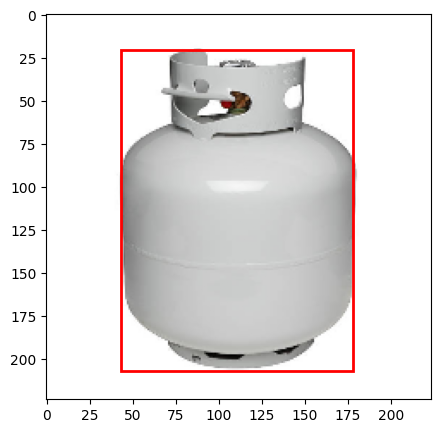

In [6]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[27]
plot_img_bbox(img, target)

In [7]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [8]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
# use our dataset and defined transformations
dataset = CylindersDataset(files_dir, 480, 480, transforms= get_transform(train=True))
dataset_test = CylindersDataset(files_dir, 480, 480, transforms= get_transform(train=False))

In [10]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.3
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [16]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

cuda


In [17]:
# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/3]  eta: 0:00:06  lr: 0.002503  loss: 1.5570 (1.5570)  loss_classifier: 1.3840 (1.3840)  loss_box_reg: 0.1585 (0.1585)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0108 (0.0108)  time: 2.1938  data: 0.4382  max mem: 8537
Epoch: [0]  [2/3]  eta: 0:00:01  lr: 0.005000  loss: 1.4728 (1.1262)  loss_classifier: 1.2901 (0.9545)  loss_box_reg: 0.1585 (0.1563)  loss_objectness: 0.0062 (0.0076)  loss_rpn_box_reg: 0.0081 (0.0078)  time: 1.3589  data: 0.1590  max mem: 8537
Epoch: [0] Total time: 0:00:04 (1.3937 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:01  model_time: 0.6824 (0.6824)  evaluator_time: 0.0027 (0.0027)  time: 1.0037  data: 0.3109  max mem: 8537
Test: Total time: 0:00:01 (1.1052 s / it)
Averaged stats: model_time: 0.6824 (0.6824)  evaluator_time: 0.0027 (0.0027)
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ I

In [18]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
    final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
    final_prediction['labels'] = final_prediction['labels'].cpu()[keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [35]:
#test_dataset = ConeImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))

# pick one image from the test set
img, target = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  2
real #boxes:  1


EXPECTED OUTPUT


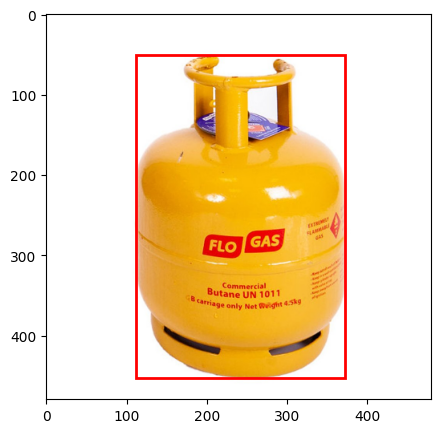

MODEL OUTPUT


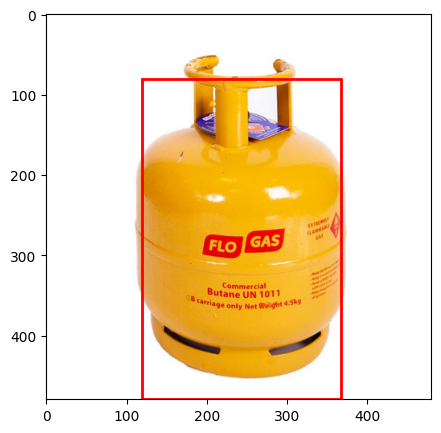

In [36]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

nms_prediction = apply_nms(prediction, iou_thresh=0.1)
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)